In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set academic plotting style
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'font.size': 11,
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'axes.axisbelow': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Make sure this path is correct
file_path = 'Copy_book2.csv'
data = pd.read_csv(file_path)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns")
print("POI categories:", data['type'].unique())

Data loaded successfully with 12 rows and 123 columns
POI categories: ['Accommodation' 'Education' 'Healthcare & Medical'
 'Financial & Professional' 'Religious' 'Residential' 'Transportation'
 'Energy & Storage' 'Outdoor Recreation' 'Public agencies'
 'Retail & Shopping' 'Entertainment']


In [2]:
# Melt the data to long format
data_long = data.melt(id_vars=['type'], var_name='Date', value_name='Mobility_Count')
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%m/%d/%y', errors='coerce')
data_long = data_long.dropna(subset=['Date'])

# Define flood periods with clear definitions
#data_long['Period'] = 'benchmark'  # Default period
data_long.loc[(data_long['Date'] >= '2020-06-01') & (data_long['Date'] <= '2020-06-11'), 'Period'] = 'benchmark'
data_long.loc[(data_long['Date'] >= '2020-06-12') & (data_long['Date'] <= '2020-06-16'), 'Period'] = 'pre_flood'
data_long.loc[(data_long['Date'] >= '2020-06-17') & (data_long['Date'] <= '2020-07-08'), 'Period'] = 'flood'
data_long.loc[(data_long['Date'] >= '2020-07-09') & (data_long['Date'] <= '2020-07-23'), 'Period'] = 'post_flood'

# Add relative time variable (days from flood onset)
flood_start = pd.to_datetime('2020-06-17')
data_long['Days_From_Flood'] = (data_long['Date'] - flood_start).dt.days

# Apply min-max scaling for each POI type
poi_types = data_long['type'].unique()
for poi_type in poi_types:
    poi_mask = data_long['type'] == poi_type
    scaler = MinMaxScaler()
    data_long.loc[poi_mask, 'MinMax_Mobility'] = scaler.fit_transform(
        data_long.loc[poi_mask, 'Mobility_Count'].values.reshape(-1, 1)
    )

# Add log-transformed mobility counts
data_long['Log_Mobility'] = np.log1p(data_long['Mobility_Count'])

# Create dummy variables for periods
data_long['PreFlood'] = np.where(data_long['Period'] == 'pre_flood', 1, 0)
data_long['Flood'] = np.where(data_long['Period'] == 'flood', 1, 0)
data_long['PostFlood'] = np.where(data_long['Period'] == 'post_flood', 1, 0)

# Set Residential as control group, all others as treatment
data_long['Treatment'] = 0  # Default all as control
data_long.loc[data_long['type'] != 'Residential', 'Treatment'] = 1  # All except Residential as treatment

# Create interaction terms for overall DiD
data_long['Treatment_PreFlood'] = data_long['Treatment'] * data_long['PreFlood']
data_long['Treatment_Flood'] = data_long['Treatment'] * data_long['Flood']
data_long['Treatment_PostFlood'] = data_long['Treatment'] * data_long['PostFlood']

print("Data preparation completed successfully")
print(f"Data shape: {data_long.shape}")
print("Period distribution:")
print(data_long['Period'].value_counts())

Data preparation completed successfully
Data shape: (1464, 14)
Period distribution:
Period
flood         264
post_flood    180
benchmark     132
pre_flood      60
Name: count, dtype: int64


Best control group candidates based on minimal flood impact:
                   benchmark_mean  benchmark_cv  pre_flood_mean  pre_flood_cv  \
Public agencies       1422.727273      0.393144           874.6      0.822145   
Residential           2092.272727      0.145539          1934.8      0.127676   
Education             1756.909091      0.236009          1605.8      0.144776   
Retail & Shopping     1878.545455      0.215099          1583.2      0.324080   
Energy & Storage       976.636364      0.322142           878.4      0.412541   

                    flood_mean  flood_cv  post_flood_mean  post_flood_cv  \
Public agencies    1402.772727  0.484275      1728.200000       0.371753   
Residential        2002.863636  0.142889      2367.000000       0.221224   
Education          1638.681818  0.159788      2606.666667       0.332687   
Retail & Shopping  2017.454545  0.219353      2648.466667       0.238383   
Energy & Storage    875.545455  0.315030      1052.400000       0.261716

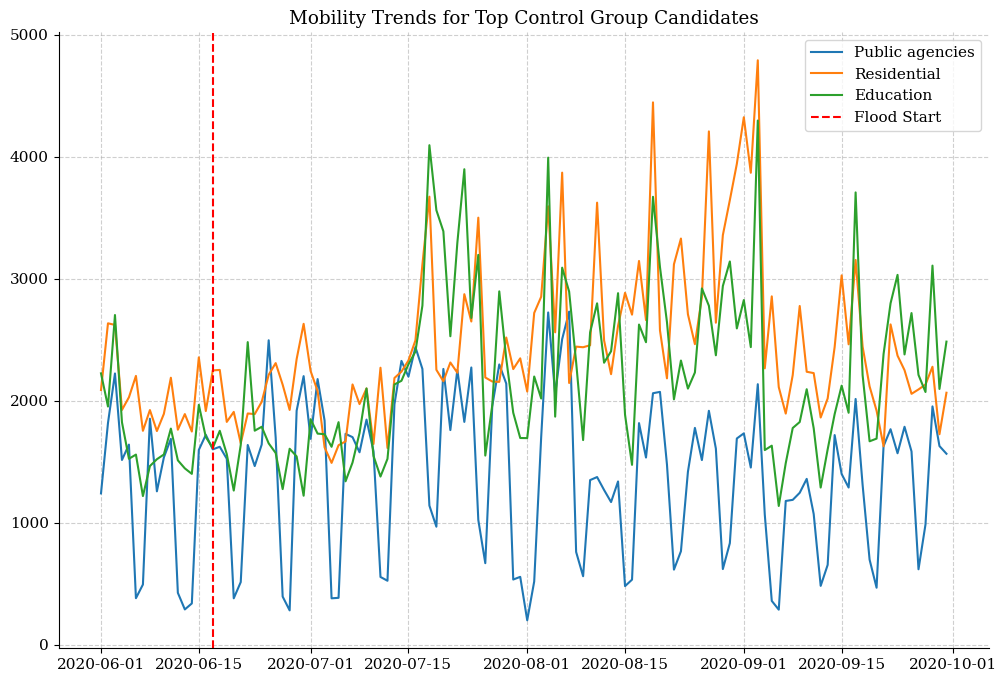

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and prepare data as in your original code
# ...

# Calculate average mobility and coefficient of variation for each period by POI type
periods = {
    'benchmark': data_long[(data_long['Date'] >= '2020-06-01') & (data_long['Date'] <= '2020-06-11')],
    'pre_flood': data_long[(data_long['Date'] >= '2020-06-12') & (data_long['Date'] <= '2020-06-16')],
    'flood': data_long[(data_long['Date'] >= '2020-06-17') & (data_long['Date'] <= '2020-07-08')],
    'post_flood': data_long[(data_long['Date'] >= '2020-07-09') & (data_long['Date'] <= '2020-07-23')]
}

# Calculate statistics for each POI type and period
stats = {}
for poi_type in data_long['type'].unique():
    stats[poi_type] = {}
    for period_name, period_data in periods.items():
        poi_period_data = period_data[period_data['type'] == poi_type]['Mobility_Count']
        stats[poi_type][f'{period_name}_mean'] = poi_period_data.mean()
        stats[poi_type][f'{period_name}_cv'] = poi_period_data.std() / poi_period_data.mean()  # coefficient of variation

    # Calculate percentage change between benchmark and flood periods
    stats[poi_type]['flood_impact'] = (stats[poi_type]['flood_mean'] - stats[poi_type]['benchmark_mean']) / stats[poi_type]['benchmark_mean'] * 100

# Convert to DataFrame for easier analysis
stats_df = pd.DataFrame.from_dict(stats, orient='index')
stats_df = stats_df.sort_values('flood_impact', key=abs)  # Sort by absolute impact

# The POI type with the smallest absolute flood_impact is potentially the best control group
print("Best control group candidates based on minimal flood impact:")
print(stats_df.head())

# Plot trends for visual confirmation
plt.figure(figsize=(12, 8))
for poi_type in stats_df.head(3).index:  # Plot the top 3 candidates
    poi_data = data_long[data_long['type'] == poi_type]
    plt.plot(poi_data['Date'], poi_data['Mobility_Count'], label=poi_type)
plt.axvline(pd.to_datetime('2020-06-17'), color='r', linestyle='--', label='Flood Start')
plt.legend()
plt.title('Mobility Trends for Top Control Group Candidates')
plt.show()

Best control group candidates (based on log-transformed data):
                   benchmark_log_mean  flood_log_mean  log_flood_change  \
Residential                  7.637373        7.592951         -0.044422   
Education                    7.448950        7.390808         -0.058142   
Retail & Shopping            7.509397        7.585488          0.076091   

                   log_stability  
Residential             0.010684  
Education               0.027505  
Retail & Shopping       0.029077  


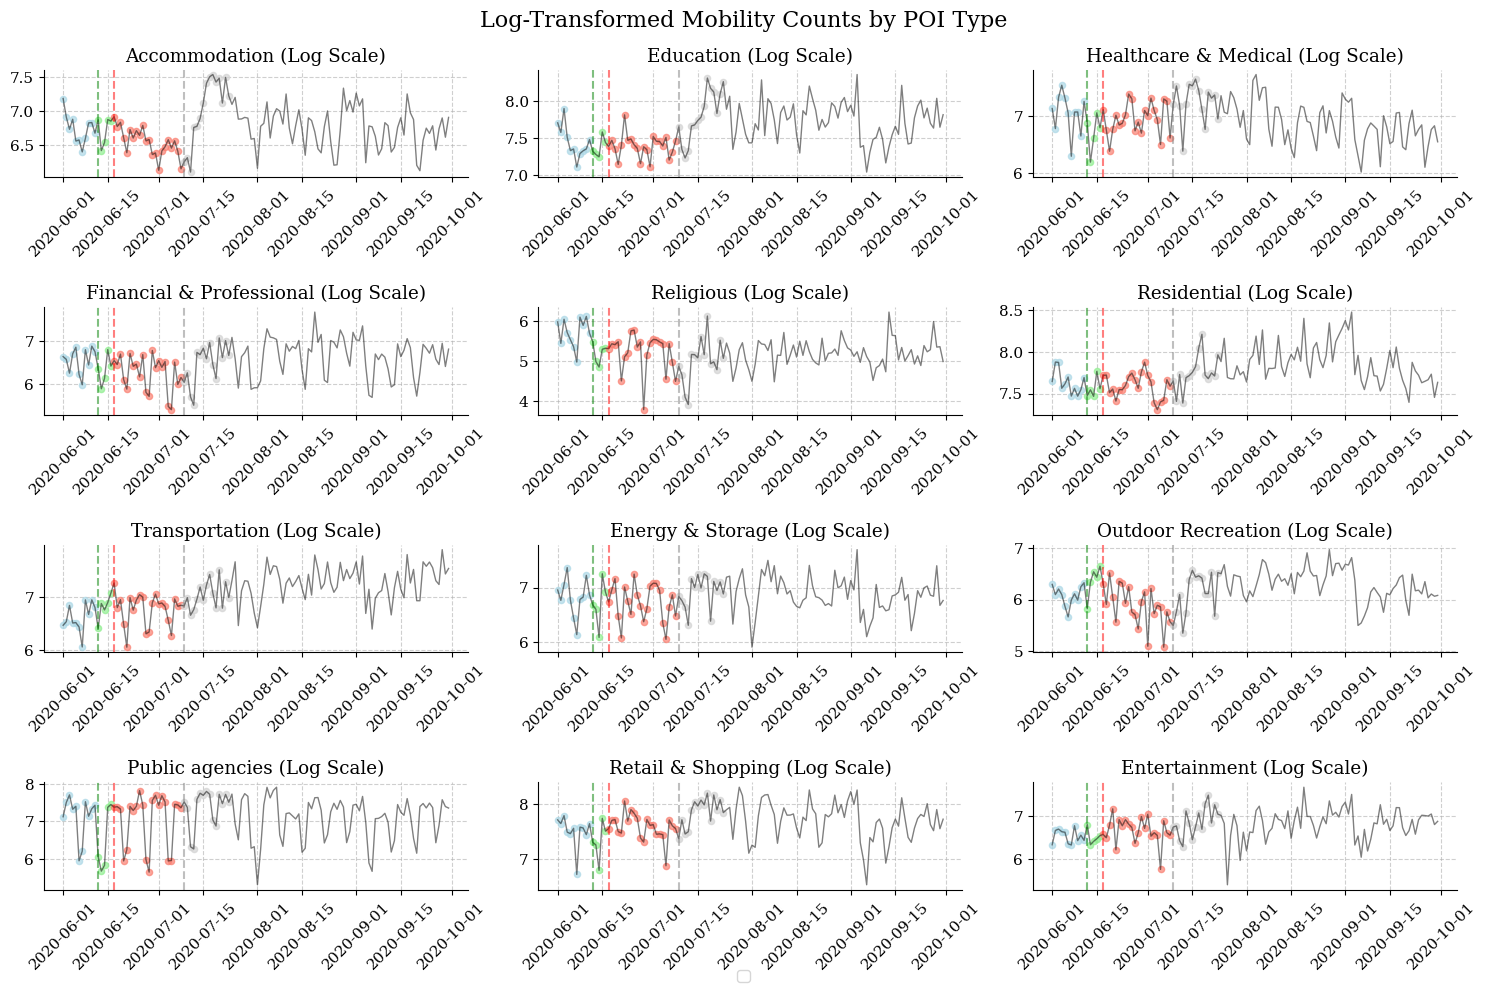

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

# Load and prepare data
file_path = 'Copy_book2.csv'
data = pd.read_csv(file_path)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Melt the data to long format
data_long = data.melt(id_vars=['type'], var_name='Date', value_name='Mobility_Count')
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%m/%d/%y', errors='coerce')
data_long = data_long.dropna(subset=['Date'])

# Define flood periods
#data_long['Period'] = 'benchmark'

data_long.loc[(data_long['Date'] >= '2020-06-01') & (data_long['Date'] <= '2020-06-11'), 'Period'] = 'benchmark'
data_long.loc[(data_long['Date'] >= '2020-06-12') & (data_long['Date'] <= '2020-06-16'), 'Period'] = 'pre_flood'
data_long.loc[(data_long['Date'] >= '2020-06-17') & (data_long['Date'] <= '2020-07-08'), 'Period'] = 'flood'
data_long.loc[(data_long['Date'] >= '2020-07-09') & (data_long['Date'] <= '2020-07-23'), 'Period'] = 'post_flood'

# Add log-transformed mobility counts (adding 1 to avoid log(0))
data_long['Log_Mobility'] = np.log1p(data_long['Mobility_Count'])

# Apply min-max scaling for each POI type
poi_types = data_long['type'].unique()
for poi_type in poi_types:
    poi_mask = data_long['type'] == poi_type
    data_long.loc[poi_mask, 'MinMax_Mobility'] = MinMaxScaler().fit_transform(
        data_long.loc[poi_mask, 'Mobility_Count'].values.reshape(-1, 1)
    )

# Calculate statistics using log transformation
stats = {}
for poi_type in poi_types:
    stats[poi_type] = {}
    poi_data = data_long[data_long['type'] == poi_type]

    # Calculate statistics for each period using log values
    for period in ['benchmark', 'pre_flood', 'flood', 'post_flood']:
        period_data = poi_data[poi_data['Period'] == period]
        stats[poi_type][f'{period}_log_mean'] = period_data['Log_Mobility'].mean()
        stats[poi_type][f'{period}_log_std'] = period_data['Log_Mobility'].std()
        stats[poi_type][f'{period}_log_cv'] = period_data['Log_Mobility'].std() / period_data['Log_Mobility'].mean()

    # Calculate percentage change from benchmark to flood period (using log values)
    stats[poi_type]['log_flood_change'] = (stats[poi_type]['flood_log_mean'] - stats[poi_type]['benchmark_log_mean'])

    # Calculate coefficient of variation across all periods (stability metric)
    all_log_values = poi_data.groupby('Period')['Log_Mobility'].mean()
    stats[poi_type]['log_stability'] = all_log_values.std() / all_log_values.mean()

# Convert to DataFrame for analysis
stats_df = pd.DataFrame.from_dict(stats, orient='index')
stats_df['abs_log_change'] = abs(stats_df['log_flood_change'])
stats_df = stats_df.sort_values(['abs_log_change', 'log_stability'])

# Create figure for log-transformed plots
plt.figure(figsize=(15, 10))

# Define colors for periods
colors = {'benchmark': 'lightblue', 'pre_flood': 'lightgreen', 'flood': 'salmon', 'post_flood': 'lightgray'}

# Plot log-transformed mobility for each POI type
for i, poi_type in enumerate(poi_types):
    plt.subplot(4, 3, i + 1)
    poi_data = data_long[data_long['type'] == poi_type]

    # Plot data points by period
    for period, color in colors.items():
        period_data = poi_data[poi_data['Period'] == period]
        plt.scatter(period_data['Date'], period_data['Log_Mobility'], c=color,
                   label=period if i == 0 else "", s=20, alpha=0.7)

    # Plot the trend line
    plt.plot(poi_data['Date'], poi_data['Log_Mobility'], 'k-', alpha=0.5, linewidth=1)

    # Add vertical lines for period boundaries
    plt.axvline(pd.to_datetime('2020-06-12'), color='green', linestyle='--', alpha=0.5)
    plt.axvline(pd.to_datetime('2020-06-17'), color='red', linestyle='--', alpha=0.5)
    plt.axvline(pd.to_datetime('2020-07-09'), color='gray', linestyle='--', alpha=0.5)

    plt.title(f"{poi_type} (Log Scale)")
    plt.xticks(rotation=45)
    plt.tight_layout()

# Add legend
handles, labels = plt.gca().get_legend_handles_labels()
fig = plt.gcf()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Log-Transformed Mobility Counts by POI Type', fontsize=16)
plt.subplots_adjust(top=0.92, bottom=0.1)

# Print top candidates for control group
print("Best control group candidates (based on log-transformed data):")
print(stats_df[['benchmark_log_mean', 'flood_log_mean', 'log_flood_change', 'log_stability']].head(3))

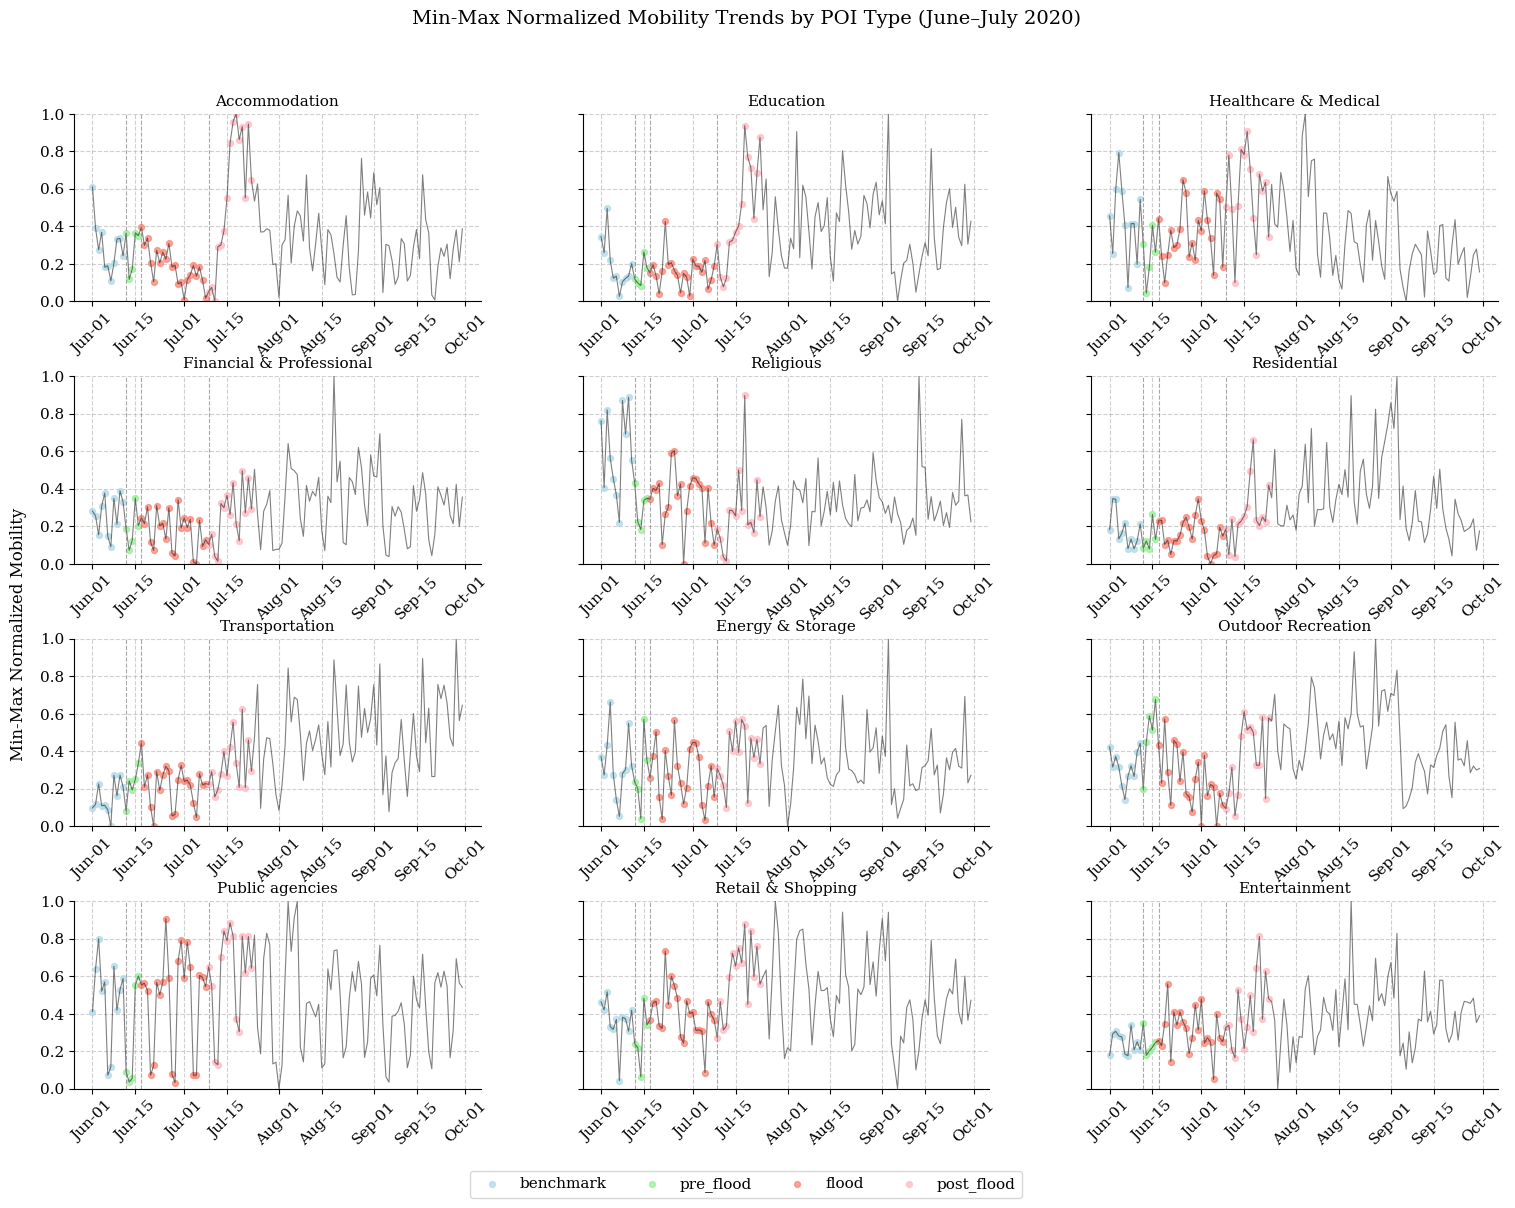

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Set academic plotting style
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],  # fallback if Times not found
    'font.size': 11,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'axes.axisbelow': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with more spacing
fig, axs = plt.subplots(4, 3, figsize=(16, 13), sharey=True)
axs = axs.flatten()

# Plot settings
ymin, ymax = 0, 1
colors = {
    'benchmark': 'lightblue',
    'pre_flood': 'lightgreen',
    'flood': 'salmon',
    'post_flood': 'lightpink'
}

# Loop through POI types
for i, poi_type in enumerate(poi_types):
    ax = axs[i]
    poi_data = data_long[data_long['type'] == poi_type]

    # Scatter per period
    for period, color in colors.items():
        period_data = poi_data[poi_data['Period'] == period]
        ax.scatter(period_data['Date'], period_data['MinMax_Mobility'],
                   c=color, label=period if i == 0 else "", s=18, alpha=0.7)

    # Trend line
    ax.plot(poi_data['Date'], poi_data['MinMax_Mobility'], 'k-', alpha=0.5, linewidth=0.8)

    # Vertical markers
    for date in ['2020-06-12', '2020-06-17', '2020-07-09']:
        ax.axvline(pd.to_datetime(date), color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

    # Format axes
    ax.set_title(poi_type, fontsize=11)
    ax.set_ylim(ymin, ymax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))  # month-day only
    ax.tick_params(axis='x', rotation=45)

# Remove individual y-axis labels
for ax in axs[1:]:
    ax.set_ylabel('')

# Shared Y-axis label
fig.text(0.04, 0.5, 'Min-Max Normalized Mobility', va='center', rotation='vertical', fontsize=12)

# Shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.06))

# Main title and layout spacing
fig.suptitle('Min-Max Normalized Mobility Trends by POI Type (June–July 2020)', fontsize=14)
fig.subplots_adjust(
    top=0.9,
    bottom=0.15,  # enough space for rotated x-ticks and legend
    left=0.08,
    right=0.97,
    hspace=0.4,
    wspace=0.25
)

plt.show()


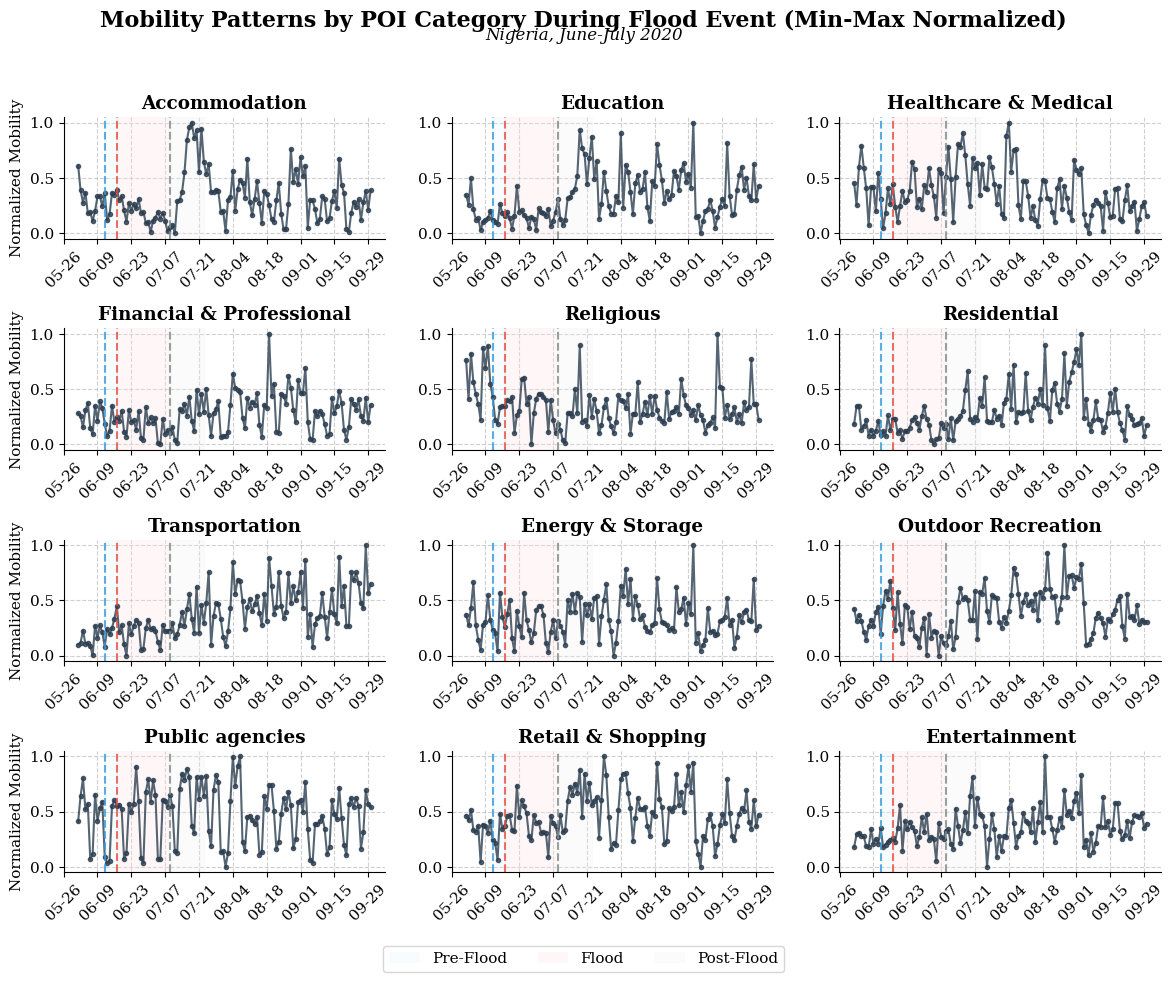

In [4]:
def create_academic_time_series():
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(4, 3, figure=fig)

    # Set period shading colors
    period_colors = {
        'pre_flood': '#e6f7ff',  # Light blue
        'flood': '#ffe6e6',      # Light red
        'post_flood': '#f2f2f2'  # Light gray
    }

    # Define period boundaries
    period_dates = {
        'pre_flood': (pd.to_datetime('2020-06-12'), pd.to_datetime('2020-06-17')),
        'flood': (pd.to_datetime('2020-06-17'), pd.to_datetime('2020-07-09')),
        'post_flood': (pd.to_datetime('2020-07-09'), pd.to_datetime('2020-07-23'))
    }

    # Create subplots for each POI type
    for i, poi_type in enumerate(poi_types):
        row, col = i // 3, i % 3
        ax = fig.add_subplot(gs[row, col])

        # Get data for this POI
        poi_data = data_long[data_long['type'] == poi_type]

        # Plot trend line with markers
        ax.plot(poi_data['Date'], poi_data['MinMax_Mobility'],
                marker='o', markersize=3, linewidth=1.5,
                color='#2c3e50', alpha=0.8)

        # Add shading for different periods
        for period, (start, end) in period_dates.items():
            ax.axvspan(start, end, alpha=0.3, color=period_colors[period])

        # Formatting
        ax.set_title(poi_type, fontweight='bold')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        ax.set_ylim([-0.05, 1.05])
        ax.tick_params(axis='x', rotation=45)

        # Add vertical lines at flood event boundaries
        ax.axvline(period_dates['pre_flood'][0], color='#3498db', linestyle='--', alpha=0.8)
        ax.axvline(period_dates['flood'][0], color='#e74c3c', linestyle='--', alpha=0.8)
        ax.axvline(period_dates['post_flood'][0], color='#7f8c8d', linestyle='--', alpha=0.8)

        # Only add y-label for leftmost plots
        if col == 0:
            ax.set_ylabel('Normalized Mobility')

    # Create custom legend for the figure
    legend_elements = [
        Patch(facecolor=period_colors['pre_flood'], edgecolor='none', alpha=0.3, label='Pre-Flood'),
        Patch(facecolor=period_colors['flood'], edgecolor='none', alpha=0.3, label='Flood'),
        Patch(facecolor=period_colors['post_flood'], edgecolor='none', alpha=0.3, label='Post-Flood')
    ]

    fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.01))

    # Add overall title and adjust layout
    fig.suptitle('Mobility Patterns by POI Category During Flood Event (Min-Max Normalized)',
                 fontsize=16, fontweight='bold', y=0.98)
    fig.text(0.5, 0.95, 'Nigeria, June-July 2020', ha='center', fontsize=12, style='italic')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig('figure1_mobility_trends.pdf')
    return fig

# Create Figure 1
fig1 = create_academic_time_series()
plt.show()

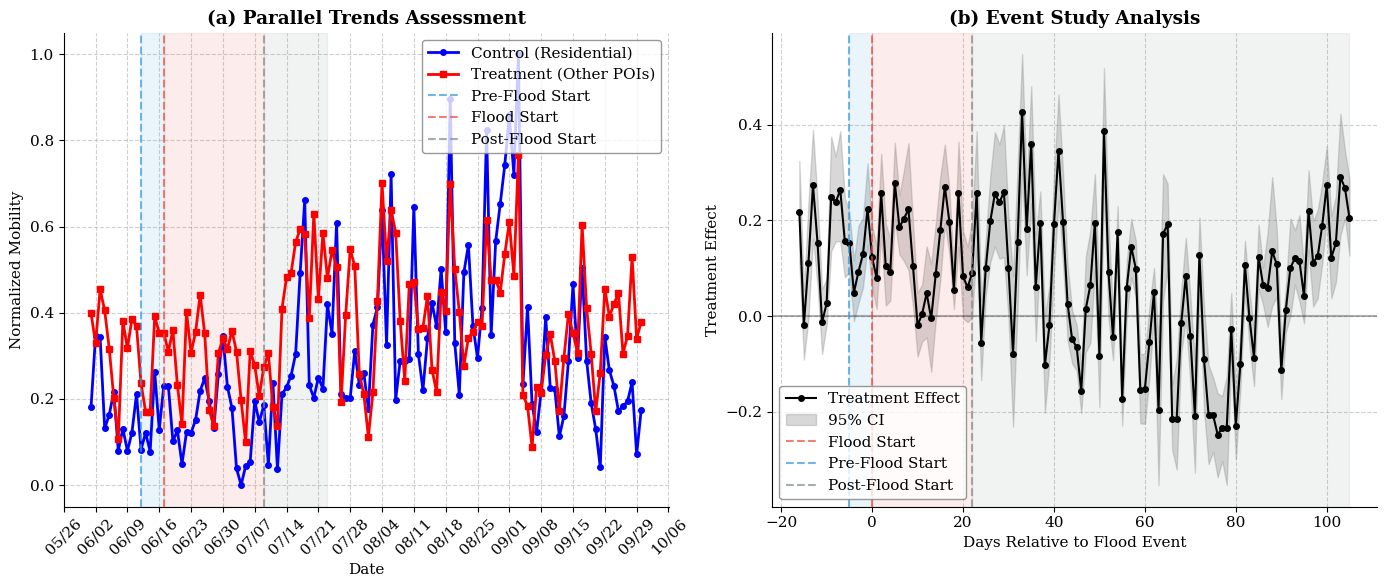

In [16]:
def create_parallel_trends_figure():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Calculate average mobility by date and treatment status
    avg_by_date = data_long.groupby(['Date', 'Treatment'])['MinMax_Mobility'].mean().reset_index()
    control_data = avg_by_date[avg_by_date['Treatment'] == 0]
    treatment_data = avg_by_date[avg_by_date['Treatment'] == 1]

    # Plot 1: Parallel trends
    ax1.plot(control_data['Date'], control_data['MinMax_Mobility'], 'b-',
             linewidth=2, label='Control (Residential)', marker='o', markersize=4)
    ax1.plot(treatment_data['Date'], treatment_data['MinMax_Mobility'], 'r-',
             linewidth=2, label='Treatment (Other POIs)', marker='s', markersize=4)

    # Add vertical lines and shading for periods
    for date, label, color in [
        (pd.to_datetime('2020-06-12'), 'Pre-Flood', '#3498db'),
        (pd.to_datetime('2020-06-17'), 'Flood', '#e74c3c'),
        (pd.to_datetime('2020-07-09'), 'Post-Flood', '#7f8c8d')
    ]:
        ax1.axvline(date, color=color, linestyle='--', alpha=0.7, label=f'{label} Start')

    ax1.axvspan(pd.to_datetime('2020-06-12'), pd.to_datetime('2020-06-17'), alpha=0.1, color='#3498db')
    ax1.axvspan(pd.to_datetime('2020-06-17'), pd.to_datetime('2020-07-09'), alpha=0.1, color='#e74c3c')
    ax1.axvspan(pd.to_datetime('2020-07-09'), pd.to_datetime('2020-07-23'), alpha=0.1, color='#7f8c8d')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Mobility')
    ax1.set_title('(a) Parallel Trends Assessment', fontweight='bold')
    ax1.legend(loc='best', frameon=True, framealpha=0.8, edgecolor='grey')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Event study visualization (FIXED VERSION)
    # Group data by days from flood and treatment status
    event_data = data_long.groupby(['Days_From_Flood', 'Treatment'])['MinMax_Mobility'].mean().reset_index()

    # Pivot to get treatment and control groups
    event_pivot = event_data.pivot_table(
        values='MinMax_Mobility',
        index='Days_From_Flood',
        columns='Treatment'
    ).reset_index()

    # Rename columns for clarity
    event_pivot.columns = ['Days_From_Flood', 'Control', 'Treatment']

    # Calculate treatment effect (Treatment - Control)
    event_pivot['Treatment_Effect'] = event_pivot['Treatment'] - event_pivot['Control']

    # Calculate standard errors and confidence intervals
    treatment_data_by_day = data_long[data_long['Treatment'] == 1].groupby('Days_From_Flood')['MinMax_Mobility']
    control_data_by_day = data_long[data_long['Treatment'] == 0].groupby('Days_From_Flood')['MinMax_Mobility']

    effects = []
    lower_ci = []
    upper_ci = []
    days = []

    for day in sorted(event_pivot['Days_From_Flood'].unique()):
        if day in treatment_data_by_day.groups and day in control_data_by_day.groups:
            treatment_vals = treatment_data_by_day.get_group(day)
            control_vals = control_data_by_day.get_group(day)

            # Calculate effect and its standard error
            effect = treatment_vals.mean() - control_vals.mean()

            # Use bootstrapping for confidence intervals
            n_boot = 1000
            boot_effects = []

            for _ in range(n_boot):
                t_sample = np.random.choice(treatment_vals, size=len(treatment_vals), replace=True)
                c_sample = np.random.choice(control_vals, size=len(control_vals), replace=True)
                boot_effects.append(np.mean(t_sample) - np.mean(c_sample))

            # 95% confidence interval
            ci_lower = np.percentile(boot_effects, 2.5)
            ci_upper = np.percentile(boot_effects, 97.5)

            effects.append(effect)
            lower_ci.append(ci_lower)
            upper_ci.append(ci_upper)
            days.append(day)

    # Plot event study
    ax2.plot(days, effects, 'ko-', markersize=4, label='Treatment Effect')
    ax2.fill_between(days, lower_ci, upper_ci, color='gray', alpha=0.3, label='95% CI')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Add vertical lines for periods
    ax2.axvline(x=0, color='#e74c3c', linestyle='--', alpha=0.7, label='Flood Start')
    ax2.axvline(x=-5, color='#3498db', linestyle='--', alpha=0.7, label='Pre-Flood Start')
    ax2.axvline(x=22, color='#7f8c8d', linestyle='--', alpha=0.7, label='Post-Flood Start')

    # Shade periods
    ax2.axvspan(-5, 0, alpha=0.1, color='#3498db')
    ax2.axvspan(0, 22, alpha=0.1, color='#e74c3c')
    ax2.axvspan(22, max(days), alpha=0.1, color='#7f8c8d')

    ax2.set_xlabel('Days Relative to Flood Event')
    ax2.set_ylabel('Treatment Effect')
    ax2.set_title('(b) Event Study Analysis', fontweight='bold')
    ax2.legend(loc='best', frameon=True, framealpha=0.8, edgecolor='grey')

    plt.tight_layout()
    plt.savefig('figure2_parallel_trends_event_study.pdf')
    return fig

# Create Figure 2
fig2 = create_parallel_trends_figure()
plt.show()

In [19]:
# Count observations per group per day
sample_size = (
    data_long
    .groupby(['Days_From_Flood', 'Treatment'])
    .size()
    .reset_index(name='Count')
    .pivot(index='Days_From_Flood', columns='Treatment', values='Count')
    .rename(columns={0: 'Control_N', 1: 'Treatment_N'})
    .fillna(0)
    .astype(int)
)

# Show first few rows
sample_size.reset_index().head(10)
sample_size.reset_index().to_csv("sample_size_by_day.csv", index=False)



Day -16: effect = 0.218, t = nan, p = nan
Day -15: effect = -0.018, t = nan, p = nan
Day -14: effect = 0.111, t = nan, p = nan
Day -13: effect = 0.274, t = nan, p = nan
Day -12: effect = 0.154, t = nan, p = nan
Day -11: effect = -0.013, t = nan, p = nan
Day -10: effect = 0.026, t = nan, p = nan
Day  -9: effect = 0.249, t = nan, p = nan
Day  -8: effect = 0.238, t = nan, p = nan
Day  -7: effect = 0.264, t = nan, p = nan
Day  -6: effect = 0.157, t = nan, p = nan
Day  -5: effect = 0.153, t = nan, p = nan
Day  -4: effect = 0.049, t = nan, p = nan
Day  -3: effect = 0.093, t = nan, p = nan
Day  -2: effect = 0.129, t = nan, p = nan
Day  -1: effect = 0.225, t = nan, p = nan
Day  +0: effect = 0.123, t = nan, p = nan
Day  +1: effect = 0.079, t = nan, p = nan
Day  +2: effect = 0.257, t = nan, p = nan
Day  +3: effect = 0.105, t = nan, p = nan
Day  +4: effect = 0.092, t = nan, p = nan
Day  +5: effect = 0.279, t = nan, p = nan
Day  +6: effect = 0.186, t = nan, p = nan
Day  +7: effect = 0.204, t = nan

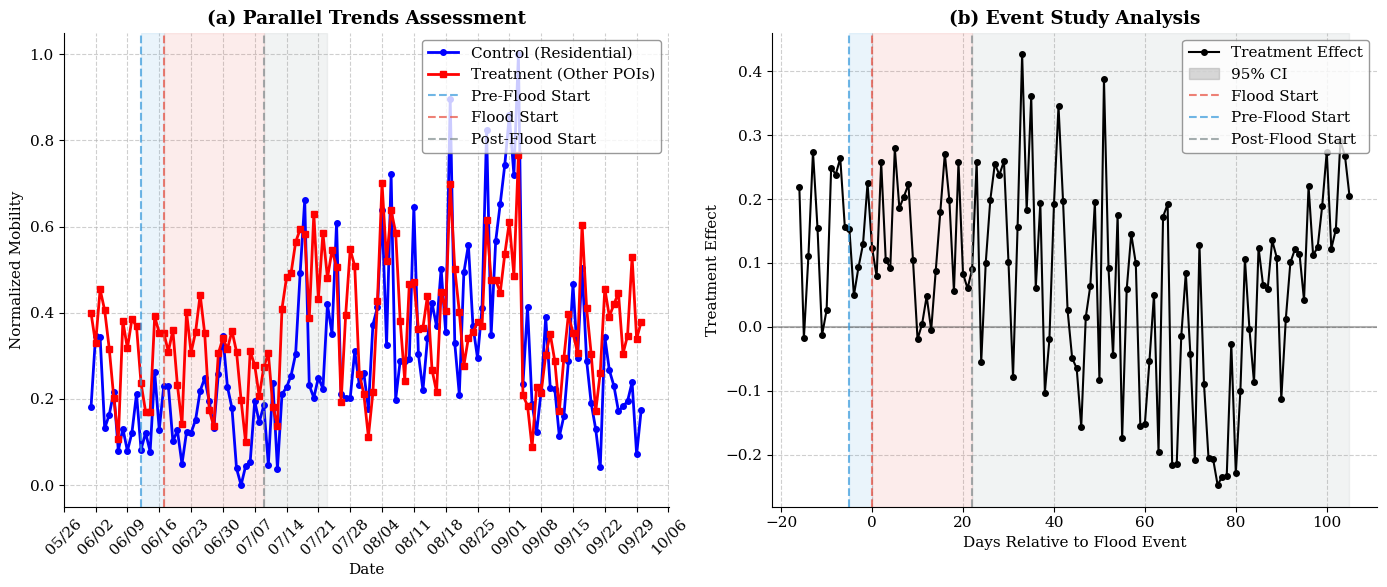

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import ttest_ind

def create_parallel_trends_figure():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Calculate average mobility by date and treatment status
    avg_by_date = data_long.groupby(['Date', 'Treatment'])['MinMax_Mobility'].mean().reset_index()
    control_data = avg_by_date[avg_by_date['Treatment'] == 0]
    treatment_data = avg_by_date[avg_by_date['Treatment'] == 1]

    # Plot 1: Parallel trends
    ax1.plot(control_data['Date'], control_data['MinMax_Mobility'], 'b-',
             linewidth=2, label='Control (Residential)', marker='o', markersize=4)
    ax1.plot(treatment_data['Date'], treatment_data['MinMax_Mobility'], 'r-',
             linewidth=2, label='Treatment (Other POIs)', marker='s', markersize=4)

    for date, label, color in [
        (pd.to_datetime('2020-06-12'), 'Pre-Flood', '#3498db'),
        (pd.to_datetime('2020-06-17'), 'Flood', '#e74c3c'),
        (pd.to_datetime('2020-07-09'), 'Post-Flood', '#7f8c8d')
    ]:
        ax1.axvline(date, color=color, linestyle='--', alpha=0.7, label=f'{label} Start')

    ax1.axvspan(pd.to_datetime('2020-06-12'), pd.to_datetime('2020-06-17'), alpha=0.1, color='#3498db')
    ax1.axvspan(pd.to_datetime('2020-06-17'), pd.to_datetime('2020-07-09'), alpha=0.1, color='#e74c3c')
    ax1.axvspan(pd.to_datetime('2020-07-09'), pd.to_datetime('2020-07-23'), alpha=0.1, color='#7f8c8d')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Mobility')
    ax1.set_title('(a) Parallel Trends Assessment', fontweight='bold')
    ax1.legend(loc='best', frameon=True, framealpha=0.8, edgecolor='grey')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Event study visualization using t-test
    event_data = data_long.groupby(['Days_From_Flood', 'Treatment'])['MinMax_Mobility'].mean().reset_index()
    event_pivot = event_data.pivot_table(
        values='MinMax_Mobility',
        index='Days_From_Flood',
        columns='Treatment'
    ).reset_index()
    event_pivot.columns = ['Days_From_Flood', 'Control', 'Treatment']
    event_pivot['Treatment_Effect'] = event_pivot['Treatment'] - event_pivot['Control']

    treatment_data_by_day = data_long[data_long['Treatment'] == 1].groupby('Days_From_Flood')['MinMax_Mobility']
    control_data_by_day = data_long[data_long['Treatment'] == 0].groupby('Days_From_Flood')['MinMax_Mobility']

    effects = []
    lower_ci = []
    upper_ci = []
    days = []
    p_vals = []

    for day in sorted(event_pivot['Days_From_Flood'].dropna().unique()):
        if day in treatment_data_by_day.groups and day in control_data_by_day.groups:
            treatment_vals = treatment_data_by_day.get_group(day)
            control_vals = control_data_by_day.get_group(day)

            effect = treatment_vals.mean() - control_vals.mean()
            se = np.sqrt(treatment_vals.var(ddof=1)/len(treatment_vals) + control_vals.var(ddof=1)/len(control_vals))
            ci_margin = 1.96 * se  # normal approximation

            t_stat, p_val = ttest_ind(treatment_vals, control_vals, equal_var=False)

            effects.append(effect)
            lower_ci.append(effect - ci_margin)
            upper_ci.append(effect + ci_margin)
            days.append(day)
            p_vals.append(p_val)

            # Print t-test result
            print(f"Day {day:+3d}: effect = {effect:.3f}, t = {t_stat:.2f}, p = {p_val:.4f}")

    # Plot event study
    ax2.plot(days, effects, 'ko-', markersize=4, label='Treatment Effect')
    ax2.fill_between(days, lower_ci, upper_ci, color='gray', alpha=0.3, label='95% CI')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    ax2.axvline(x=0, color='#e74c3c', linestyle='--', alpha=0.7, label='Flood Start')
    ax2.axvline(x=-5, color='#3498db', linestyle='--', alpha=0.7, label='Pre-Flood Start')
    ax2.axvline(x=22, color='#7f8c8d', linestyle='--', alpha=0.7, label='Post-Flood Start')

    ax2.axvspan(-5, 0, alpha=0.1, color='#3498db')
    ax2.axvspan(0, 22, alpha=0.1, color='#e74c3c')
    ax2.axvspan(22, max(days), alpha=0.1, color='#7f8c8d')

    ax2.set_xlabel('Days Relative to Flood Event')
    ax2.set_ylabel('Treatment Effect')
    ax2.set_title('(b) Event Study Analysis', fontweight='bold')
    ax2.legend(loc='best', frameon=True, framealpha=0.8, edgecolor='grey')

    plt.tight_layout()
    plt.savefig('figure2_parallel_trends_event_study.pdf')

    # Optionally return t-test results
    ttest_results = pd.DataFrame({
        'Days_From_Flood': days,
        'Effect': effects,
        'CI_Lower': lower_ci,
        'CI_Upper': upper_ci,
        'P_Value': p_vals
    })

    return fig, ttest_results

# Create Figure 2 and get t-test results
fig2, ttest_table = create_parallel_trends_figure()
plt.show()


In [23]:
# Use bootstrapping to estimate confidence intervals for treatment effects

# Reset lists
boot_effects = []
boot_lower_ci = []
boot_upper_ci = []
boot_days = []

n_boot = 1000  # number of bootstrap samples

# Define treatment_data_by_day and control_data_by_day before the loop
treatment_data_by_day = data_long[data_long['Treatment'] == 1].groupby('Days_From_Flood')['MinMax_Mobility']
control_data_by_day = data_long[data_long['Treatment'] == 0].groupby('Days_From_Flood')['MinMax_Mobility']


for day in sorted(data_long['Days_From_Flood'].dropna().unique()):
    if day in treatment_data_by_day.groups and day in control_data_by_day.groups:
        treatment_vals = treatment_data_by_day.get_group(day).values
        control_vals = control_data_by_day.get_group(day).values

        effect = np.mean(treatment_vals) - np.mean(control_vals)
        boots = []

        for _ in range(n_boot):
            t_sample = np.random.choice(treatment_vals, size=len(treatment_vals), replace=True)
            c_sample = np.random.choice(control_vals, size=len(control_vals), replace=True)
            boots.append(np.mean(t_sample) - np.mean(c_sample))

        ci_lower = np.percentile(boots, 2.5)
        ci_upper = np.percentile(boots, 97.5)

        boot_effects.append(effect)
        boot_lower_ci.append(ci_lower)
        boot_upper_ci.append(ci_upper)
        boot_days.append(day)

# Create bootstrap-based results table
boot_ci_table = pd.DataFrame({
    'Days_From_Flood': boot_days,
    'Effect': boot_effects,
    'CI_Lower': boot_lower_ci,
    'CI_Upper': boot_upper_ci
})

# Instead of using tools.display_dataframe_to_user, just display the DataFrame
# using the display function from IPython.display, which is already imported.
display(boot_ci_table) # Assuming this was the intent of tools.display_dataframe_to_user

,Days_From_Flood,Effect,CI_Lower,CI_Upper
0,-16,0.218245,0.115615,0.324610
1,-15,-0.017869,-0.084545,0.057300
2,-14,0.111240,-0.011492,0.235407
3,-13,0.273997,0.163655,0.389744
4,-12,0.153880,0.064015,0.253980
...,...,...,...,...
117,101,0.122443,0.033740,0.206628
118,102,0.152107,0.071184,0.262276
119,103,0.290627,0.175849,0.413161
120,104,0.267862,0.199723,0.351099


In [7]:
# Create a table of individual POI period effects
regression_results = {}

for poi_type in poi_types:
    # Filter data for just this POI type
    poi_data = data_long[data_long['type'] == poi_type].copy()

    # Run regression for this POI
    model = smf.ols(
        formula='MinMax_Mobility ~ PreFlood + Flood + PostFlood',
        data=poi_data
    )
    results = model.fit()

    # Store results with significance stars
    def format_coef(coef, pval):
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        return f"{coef:.4f}{stars}"

    regression_results[poi_type] = {
        'PreFlood': format_coef(results.params['PreFlood'], results.pvalues['PreFlood']),
        'Flood': format_coef(results.params['Flood'], results.pvalues['Flood']),
        'PostFlood': format_coef(results.params['PostFlood'], results.pvalues['PostFlood']),
        'Observations': int(results.nobs),
        'R-squared': f"{results.rsquared:.3f}"
    }

# Convert to DataFrame
table1 = pd.DataFrame(regression_results).T
table1.index.name = 'POI Category'

# Print and save table
print("\nTable 1: Period Effects by POI Category (Min-Max Scaled)")
print("-" * 80)
print(table1.to_string())
table1.to_csv('table1_period_effects.csv')


Table 1: Period Effects by POI Category (Min-Max Scaled)
--------------------------------------------------------------------------------
                           PreFlood       Flood  PostFlood Observations R-squared
POI Category                                                                     
Accommodation               -0.0389  -0.1263***  0.2469***          122     0.223
Education                 -0.2112**  -0.2008***    0.1056*          122     0.203
Healthcare & Medical        -0.1055      0.0179  0.2233***          122     0.131
Financial & Professional   -0.1269*  -0.1372***    -0.0572          122     0.113
Religious                   -0.0519     -0.0166    -0.0789          122     0.021
Residential               -0.2016**  -0.1810***    -0.0707          122     0.152
Transportation            -0.2170**  -0.2235***   -0.1095*          122     0.184
Energy & Storage            -0.0705    -0.0721*     0.0241          122     0.034
Outdoor Recreation           0.0472  -0.1

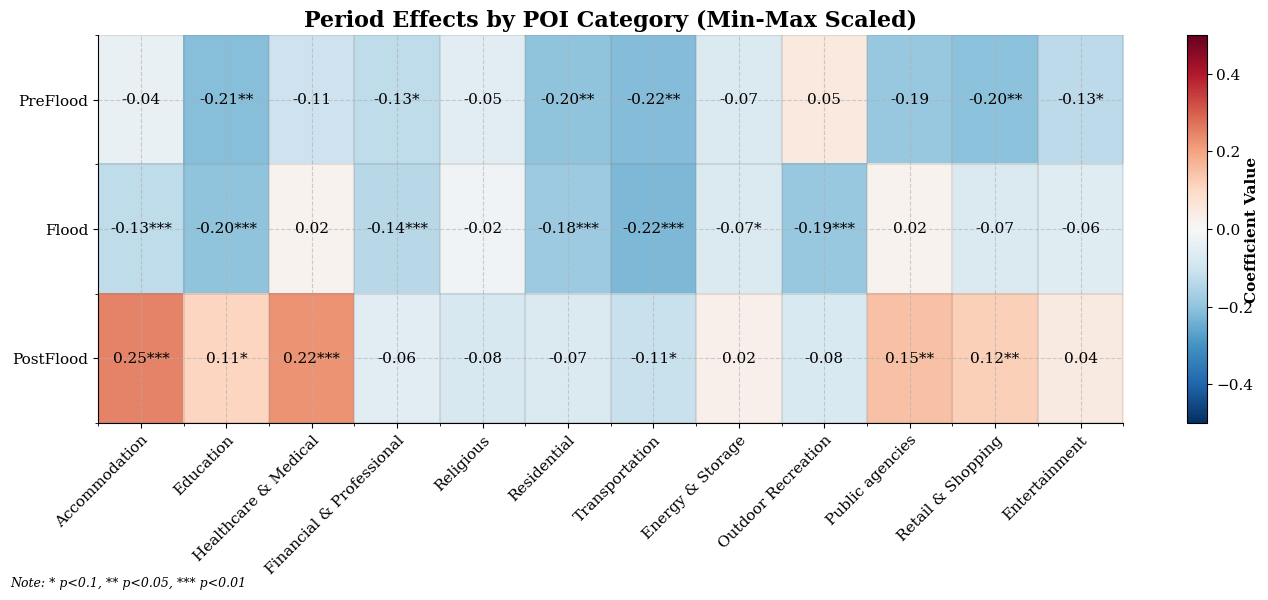

In [8]:
def create_heatmap_figure():
    # Run separate regressions for each POI type and format results for heatmap
    regression_results = {}

    for poi_type in poi_types:
        # Filter data for just this POI type
        poi_data = data_long[data_long['type'] == poi_type].copy()

        # Run regression for this POI
        model = smf.ols(
            formula='MinMax_Mobility ~ PreFlood + Flood + PostFlood',
            data=poi_data
        )
        results = model.fit()

        # Store results
        regression_results[poi_type] = {
            'PreFlood': results.params['PreFlood'],
            'PreFlood_p': results.pvalues['PreFlood'],
            'Flood': results.params['Flood'],
            'Flood_p': results.pvalues['Flood'],
            'PostFlood': results.params['PostFlood'],
            'PostFlood_p': results.pvalues['PostFlood'],
        }

    # Create DataFrames for coefficients and p-values
    coef_df = pd.DataFrame({
        poi: [regression_results[poi]['PreFlood'],
              regression_results[poi]['Flood'],
              regression_results[poi]['PostFlood']]
        for poi in poi_types
    }, index=['PreFlood', 'Flood', 'PostFlood'])

    pval_df = pd.DataFrame({
        poi: [regression_results[poi]['PreFlood_p'],
              regression_results[poi]['Flood_p'],
              regression_results[poi]['PostFlood_p']]
        for poi in poi_types
    }, index=['PreFlood', 'Flood', 'PostFlood'])

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))

    # Create heatmap
    im = ax.imshow(coef_df, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Coefficient Value', rotation=90, va='bottom', fontweight='bold')

    # Add significance markers
    for i in range(len(coef_df.index)):
        for j in range(len(coef_df.columns)):
            text = f"{coef_df.iloc[i, j]:.2f}"
            p_val = pval_df.iloc[i, j]
            if p_val < 0.01:
                text += '***'
            elif p_val < 0.05:
                text += '**'
            elif p_val < 0.1:
                text += '*'
            ax.text(j, i, text, ha="center", va="center",
                   color="white" if abs(coef_df.iloc[i, j]) > 0.25 else "black")

    # Set tick labels
    ax.set_xticks(np.arange(len(coef_df.columns)))
    ax.set_yticks(np.arange(len(coef_df.index)))
    ax.set_xticklabels(coef_df.columns)
    ax.set_yticklabels(coef_df.index)

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add title and labels
    ax.set_title('Period Effects by POI Category (Min-Max Scaled)', fontsize=16, fontweight='bold')

    # Add gridlines to make cells more visible
    ax.set_xticks(np.arange(coef_df.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(coef_df.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=1.5, alpha=0.2)

    # Add note about significance levels
    fig.text(0.01, 0.01, "Note: * p<0.1, ** p<0.05, *** p<0.01", ha="left", fontsize=9, style='italic')

    plt.tight_layout()
    plt.savefig('figure4_coefficient_heatmap.pdf')
    return fig

# Create Figure 4
fig4 = create_heatmap_figure()
plt.show()

<Figure size 1400x800 with 0 Axes>

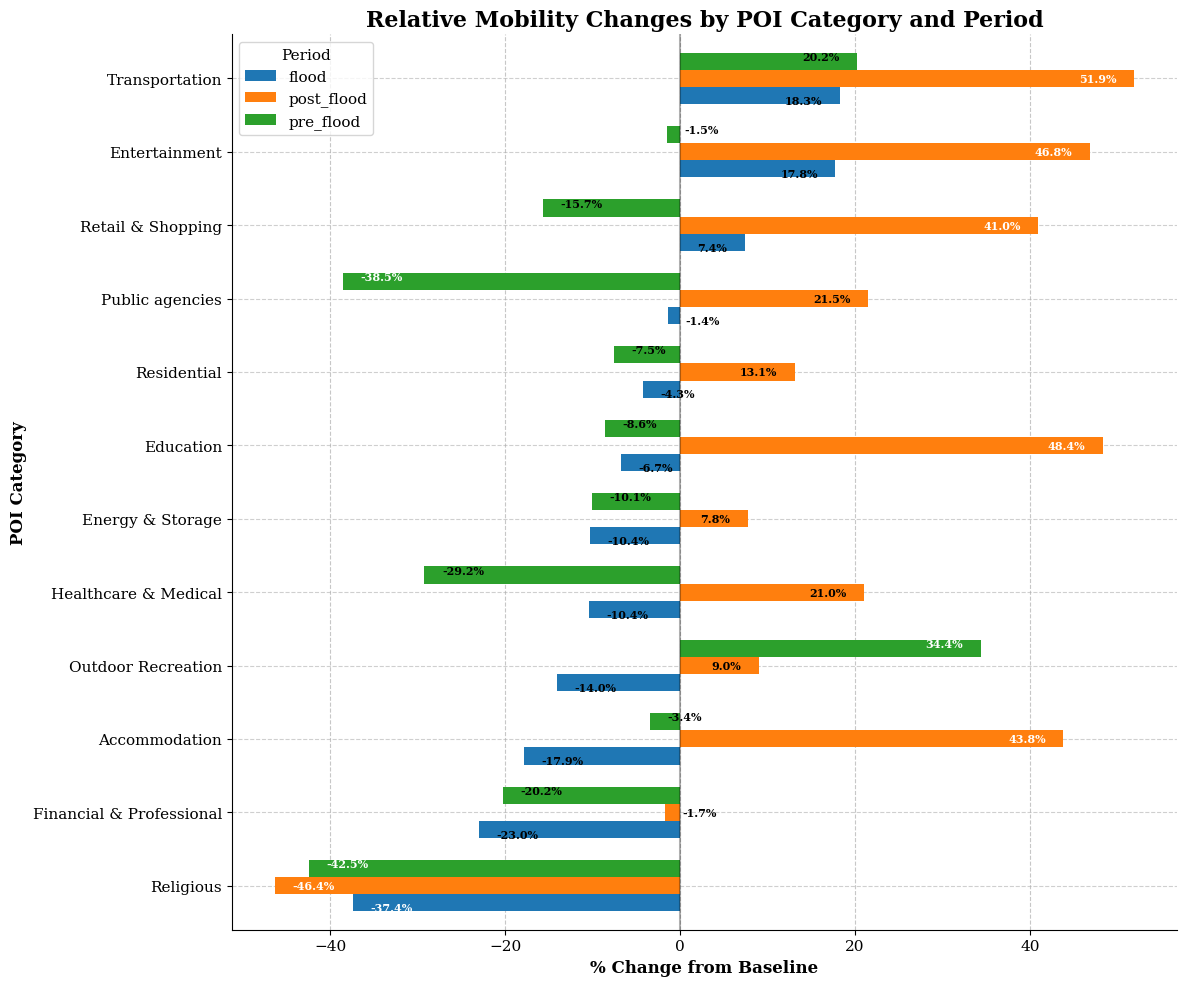

In [9]:
def create_comparative_analysis_figure():
    # Calculate baseline (benchmark) period average for each POI
    baseline_avg = data_long[data_long['Period'] == 'benchmark'].groupby('type')['Mobility_Count'].mean()

    # Calculate relative changes for all periods compared to baseline
    data_long['Relative_Change'] = 0.0
    for poi_type in poi_types:
        poi_mask = data_long['type'] == poi_type
        baseline = baseline_avg[poi_type]
        data_long.loc[poi_mask, 'Relative_Change'] = ((data_long.loc[poi_mask, 'Mobility_Count'] / baseline) - 1) * 100

    # Create a figure showing comparative relative changes
    plt.figure(figsize=(14, 8))

    # Calculate average relative change by period for each POI type
    rel_changes = data_long.groupby(['type', 'Period'])['Relative_Change'].mean().reset_index()
    rel_changes = rel_changes[rel_changes['Period'] != 'benchmark']  # Remove benchmark (always 0%)

    # Pivot the data for easier plotting
    pivot_changes = rel_changes.pivot(index='type', columns='Period', values='Relative_Change')

    # Sort by flood period impact
    pivot_changes = pivot_changes.sort_values('flood')

    # Plot
    ax = pivot_changes.plot(kind='barh', figsize=(12, 10), width=0.7)

    # Add a vertical line at 0
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # Customize the plot
    plt.xlabel('% Change from Baseline', fontsize=12, fontweight='bold')
    plt.ylabel('POI Category', fontsize=12, fontweight='bold')
    plt.title('Relative Mobility Changes by POI Category and Period',
              fontsize=16, fontweight='bold')
    plt.legend(title='Period')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add value labels
    for i, period in enumerate(pivot_changes.columns):
        for j, value in enumerate(pivot_changes[period]):
            text_color = 'white' if abs(value) > 30 else 'black'
            ax.text(value + (2 if value < 0 else -2),
                   j + (0.3 if i == 2 else 0 if i == 1 else -0.3),
                   f"{value:.1f}%",
                   va='center', ha='right' if value > 0 else 'left',
                   color=text_color, fontweight='bold', fontsize=8)

    plt.tight_layout()
    plt.savefig('figure5_comparative_analysis.pdf')
    return plt.gcf()

# Create Figure 5
fig5 = create_comparative_analysis_figure()
plt.show()

In [10]:
# Run separate DiD regressions for each POI type vs. Residential (Fixed Version)
poi_types_treatment = [pt for pt in poi_types if pt != 'Residential']
did_results = {}

for poi_type in poi_types_treatment:
    print(f"Processing DiD for {poi_type}...")

    # Filter data for just this POI type and Residential
    compare_data = data_long[data_long['type'].isin([poi_type, 'Residential'])].copy()

    # Set treatment indicator (1 for this POI type, 0 for Residential)
    compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)

    # Create interaction terms specifically for this comparison
    compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
    compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
    compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

    # Verify variables exist in the dataframe
    for col in ['POI_Treatment', 'PreFlood', 'Flood', 'PostFlood',
                'POI_PreFlood_Int', 'POI_Flood_Int', 'POI_PostFlood_Int']:
        if col not in compare_data.columns:
            print(f"ERROR: Column {col} missing for {poi_type}")

    # Run DiD regression - with explicit column references
    formula = ('MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + ' +
               'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int')

    model = smf.ols(formula=formula, data=compare_data)
    results = model.fit()

    # Format results with significance stars
    def format_coef_with_se(coef, se, pval):
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        return f"{coef:.4f}{stars}\n({se:.4f})"

    # Store the results
    did_results[poi_type] = {
        'Treatment×PreFlood': format_coef_with_se(
            results.params['POI_PreFlood_Int'],
            results.bse['POI_PreFlood_Int'],
            results.pvalues['POI_PreFlood_Int']
        ),
        'Treatment×Flood': format_coef_with_se(
            results.params['POI_Flood_Int'],
            results.bse['POI_Flood_Int'],
            results.pvalues['POI_Flood_Int']
        ),
        'Treatment×PostFlood': format_coef_with_se(
            results.params['POI_PostFlood_Int'],
            results.bse['POI_PostFlood_Int'],
            results.pvalues['POI_PostFlood_Int']
        ),
        'Observations': int(results.nobs),
        'R-squared': f"{results.rsquared:.3f}"
    }

# Convert to DataFrame and sort by Flood impact
table2 = pd.DataFrame(did_results).T
table2.index.name = 'POI Category vs. Residential'

# Print and save table
print("\nTable 2: Difference-in-Differences Results by POI Category (vs. Residential)")
print("-" * 80)
print(table2.to_string())
table2.to_csv('table2_did_results.csv')

Processing DiD for Accommodation...
Processing DiD for Education...
Processing DiD for Healthcare & Medical...
Processing DiD for Financial & Professional...
Processing DiD for Religious...
Processing DiD for Transportation...
Processing DiD for Energy & Storage...
Processing DiD for Outdoor Recreation...
Processing DiD for Public agencies...
Processing DiD for Retail & Shopping...
Processing DiD for Entertainment...

Table 2: Difference-in-Differences Results by POI Category (vs. Residential)
--------------------------------------------------------------------------------
                              Treatment×PreFlood      Treatment×Flood  Treatment×PostFlood Observations R-squared
POI Category vs. Residential                                                                                     
Accommodation                   0.1628\n(0.1223)     0.0547\n(0.0639)  0.3176***\n(0.0746)          244     0.196
Education                      -0.0095\n(0.1231)    -0.0198\n(0.0643)   0.1763

In [25]:
# Import necessary libraries
import pandas as pd
import statsmodels.formula.api as smf

# Load your data (adjust file path as needed)
# from google.colab import files
# uploaded = files.upload()
# data_long = pd.read_csv('your_file.csv')

# Assuming `data_long` and `poi_types` already exist from your previous code
# If not, you'll need to load and prepare them as shown earlier

# Ensure necessary columns exist
poi_types = data_long['type'].unique()
poi_types_treatment = [pt for pt in poi_types if pt != 'Religious']

did_religious_results = {}

for poi_type in poi_types_treatment:
    compare_data = data_long[data_long['type'].isin([poi_type, 'Religious'])].copy()
    compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)
    compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
    compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
    compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

    formula = (
        'MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + '
        'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int'
    )

    model = smf.ols(formula=formula, data=compare_data)
    results = model.fit()

    def format_coef_with_se(coef, se, pval):
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        return f"{coef:.4f}{stars}\n({se:.4f})"

    did_religious_results[poi_type] = {
        'Treatment×PreFlood': format_coef_with_se(
            results.params['POI_PreFlood_Int'], results.bse['POI_PreFlood_Int'], results.pvalues['POI_PreFlood_Int']),
        'Treatment×Flood': format_coef_with_se(
            results.params['POI_Flood_Int'], results.bse['POI_Flood_Int'], results.pvalues['POI_Flood_Int']),
        'Treatment×PostFlood': format_coef_with_se(
            results.params['POI_PostFlood_Int'], results.bse['POI_PostFlood_Int'], results.pvalues['POI_PostFlood_Int']),
        'Observations': int(results.nobs),
        'R-squared': f"{results.rsquared:.3f}"
    }

# Convert results to DataFrame
table3 = pd.DataFrame(did_religious_results).T
table3.index.name = 'POI Category vs. Religious'

# Display the table
from IPython.display import display
display(table3)


,Treatment×PreFlood,Treatment×Flood,Treatment×PostFlood,Observations,R-squared
POI Category vs. Religious,,,,,
Accommodation,0.0130\n(0.1227),-0.1097*\n(0.0641),0.3259***\n(0.0749),244,0.143
Education,-0.1593\n(0.1236),-0.1842***\n(0.0645),0.1846**\n(0.0754),244,0.129
Healthcare & Medical,-0.0536\n(0.1257),0.0345\n(0.0656),0.3022***\n(0.0767),244,0.090
Financial & Professional,-0.0750\n(0.1117),-0.1206**\n(0.0583),0.0217\n(0.0682),244,0.095
Residential,-0.1498\n(0.1189),-0.1645***\n(0.0621),0.0083\n(0.0726),244,0.110
Transportation,-0.1651\n(0.1241),-0.2070***\n(0.0648),-0.0306\n(0.0758),244,0.122
Energy & Storage,-0.0186\n(0.1167),-0.0555\n(0.0609),0.1030\n(0.0712),244,0.028
Outdoor Recreation,0.0991\n(0.1185),-0.1743***\n(0.0619),0.0016\n(0.0723),244,0.109
Public agencies,-0.1376\n(0.1427),0.0358\n(0.0745),0.2268***\n(0.0871),244,0.123


In [27]:
import pandas as pd
import statsmodels.formula.api as smf

# Assume data_long and poi_types are already defined and preprocessed

# Define composite control group
low_impact_controls = ['Religious', 'Residential']
poi_types_treatment = [pt for pt in poi_types if pt not in low_impact_controls]

# Dictionary to store results
did_composite_results = {}

# Loop over each POI type not in the control group
for poi_type in poi_types_treatment:
    compare_data = data_long[data_long['type'].isin([poi_type] + low_impact_controls)].copy()

    # Define treatment indicator
    compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)

    # Interaction terms for DiD
    compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
    compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
    compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

    # DiD formula
    formula = (
        'MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + '
        'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int'
    )

    # Fit model
    model = smf.ols(formula=formula, data=compare_data)
    results = model.fit()

    # Format output with significance stars
    def format_coef_with_se(coef, se, pval):
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        return f"{coef:.4f}{stars}\n({se:.4f})"

    # Store formatted results
    did_composite_results[poi_type] = {
        'Treatment×PreFlood': format_coef_with_se(
            results.params['POI_PreFlood_Int'], results.bse['POI_PreFlood_Int'], results.pvalues['POI_PreFlood_Int']),
        'Treatment×Flood': format_coef_with_se(
            results.params['POI_Flood_Int'], results.bse['POI_Flood_Int'], results.pvalues['POI_Flood_Int']),
        'Treatment×PostFlood': format_coef_with_se(
            results.params['POI_PostFlood_Int'], results.bse['POI_PostFlood_Int'], results.pvalues['POI_PostFlood_Int']),
        'Observations': int(results.nobs),
        'R-squared': f"{results.rsquared:.3f}"
    }

# Convert to DataFrame
table_composite = pd.DataFrame(did_composite_results).T
table_composite.index.name = 'POI Category vs. Composite (Religious + Residential)'

# Display the table
from IPython.display import display
display(table_composite)


,Treatment×PreFlood,Treatment×Flood,Treatment×PostFlood,Observations,R-squared
POI Category vs. Composite (Religious + Residential),,,,,
Accommodation,0.0879\n(0.1064),-0.0275\n(0.0556),0.3217***\n(0.0650),366,0.122
Education,-0.0844\n(0.1069),-0.1020*\n(0.0558),0.1804***\n(0.0653),366,0.115
Healthcare & Medical,0.0213\n(0.1081),0.1167**\n(0.0565),0.2981***\n(0.0660),366,0.102
Financial & Professional,-0.0001\n(0.1002),-0.0384\n(0.0523),0.0176\n(0.0612),366,0.081
Transportation,-0.0902\n(0.1072),-0.1247**\n(0.0560),-0.0347\n(0.0655),366,0.124
Energy & Storage,0.0562\n(0.1030),0.0267\n(0.0538),0.0989\n(0.0629),366,0.054
Outdoor Recreation,0.1740*\n(0.1040),-0.0921*\n(0.0543),-0.0026\n(0.0635),366,0.125
Public agencies,-0.0627\n(0.1181),0.1181*\n(0.0617),0.2227***\n(0.0721),366,0.159
Retail & Shopping,-0.0770\n(0.1077),0.0263\n(0.0562),0.1932***\n(0.0657),366,0.182


In [28]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# --- Prepare composite control and POI list ---
low_impact_controls = ['Religious', 'Residential']
poi_types = data_long['type'].unique()
poi_types_treatment = [pt for pt in poi_types if pt not in low_impact_controls]

# --- Run DiD regressions ---
did_composite_results = {}

for poi_type in poi_types_treatment:
    compare_data = data_long[data_long['type'].isin([poi_type] + low_impact_controls)].copy()

    # Define treatment and interaction terms
    compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)
    compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
    compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
    compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

    # Run DiD model
    formula = (
        'MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + '
        'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int'
    )
    model = smf.ols(formula=formula, data=compare_data)
    results = model.fit()

    # Store raw beta for flood effect
    did_composite_results[poi_type] = results.params['POI_Flood_Int']

# --- Convert to percent change using exp(beta) - 1 ---
flood_effects_pct = {
    'POI': [],
    'Flood_Percent_Change': []
}

for poi, beta in did_composite_results.items():
    pct = (np.exp(beta) - 1) * 100
    flood_effects_pct['POI'].append(poi)
    flood_effects_pct['Flood_Percent_Change'].append(pct)

# --- Create and show DataFrame ---
flood_df = pd.DataFrame(flood_effects_pct)
flood_df = flood_df.sort_values('Flood_Percent_Change')

from IPython.display import display
display(flood_df)


,POI,Flood_Percent_Change
4,Transportation,-11.726793
1,Education,-9.695950
6,Outdoor Recreation,-8.797850
3,Financial & Professional,-3.763839
0,Accommodation,-2.711243
8,Retail & Shopping,2.667694
5,Energy & Storage,2.706678
9,Entertainment,3.940042
2,Healthcare & Medical,12.376276
7,Public agencies,12.530199


In [29]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display

# --- Load your data ---
# If needed, upload first:
# from google.colab import files
# uploaded = files.upload()
# data_long = pd.read_csv('your_file.csv')

# --- Example Preprocessing (adapt as needed) ---
# Assume data_long has 'Date', 'type', and 'Mobility_Count'
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%m/%d/%y', errors='coerce')
data_long = data_long.dropna(subset=['Date'])

# Define periods
data_long['Period'] = 'benchmark'
data_long.loc[(data_long['Date'] >= '2020-06-12') & (data_long['Date'] <= '2020-06-16'), 'Period'] = 'pre_flood'
data_long.loc[(data_long['Date'] >= '2020-06-17') & (data_long['Date'] <= '2020-07-08'), 'Period'] = 'flood'
data_long.loc[(data_long['Date'] >= '2020-07-09') & (data_long['Date'] <= '2020-07-23'), 'Period'] = 'post_flood'

# Normalize Mobility by POI
from sklearn.preprocessing import MinMaxScaler
for poi in data_long['type'].unique():
    mask = data_long['type'] == poi
    scaler = MinMaxScaler()
    data_long.loc[mask, 'MinMax_Mobility'] = scaler.fit_transform(data_long.loc[mask, ['Mobility_Count']])

# Add dummy variables
data_long['PreFlood'] = (data_long['Period'] == 'pre_flood').astype(int)
data_long['Flood'] = (data_long['Period'] == 'flood').astype(int)
data_long['PostFlood'] = (data_long['Period'] == 'post_flood').astype(int)

# --- DiD using Religious + Residential as Composite Control ---
low_impact_controls = ['Religious', 'Residential']
poi_types = data_long['type'].unique()
poi_types_treatment = [pt for pt in poi_types if pt not in low_impact_controls]

results_pct = {
    'POI': [],
    'PreFlood_%': [],
    'Flood_%': [],
    'PostFlood_%': []
}

for poi_type in poi_types_treatment:
    compare_data = data_long[data_long['type'].isin([poi_type] + low_impact_controls)].copy()
    compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)
    compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
    compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
    compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

    formula = (
        'MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + '
        'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int'
    )
    model = smf.ols(formula=formula, data=compare_data)
    results = model.fit()

    # Extract interaction effects and convert to %
    def pct_change(beta):
        return (np.exp(beta) - 1) * 100

    results_pct['POI'].append(poi_type)
    results_pct['PreFlood_%'].append(pct_change(results.params['POI_PreFlood_Int']))
    results_pct['Flood_%'].append(pct_change(results.params['POI_Flood_Int']))
    results_pct['PostFlood_%'].append(pct_change(results.params['POI_PostFlood_Int']))

# --- Display final percent change table ---
df_pct = pd.DataFrame(results_pct)
df_pct = df_pct.sort_values('Flood_%')
display(df_pct)


,POI,PreFlood_%,Flood_%,PostFlood_%
4,Transportation,-8.628744,-11.726793,-3.408599
1,Education,-8.095543,-9.695950,19.775396
6,Outdoor Recreation,19.006964,-8.797850,-0.255833
3,Financial & Professional,-0.013159,-3.763839,1.772946
0,Accommodation,9.187473,-2.711243,37.953754
8,Retail & Shopping,-7.411966,2.667694,21.306845
5,Energy & Storage,5.784660,2.706678,10.394542
9,Entertainment,-0.272181,3.940042,12.679957
2,Healthcare & Medical,2.153410,12.376276,34.725397
7,Public agencies,-6.080893,12.530199,24.943757


In [30]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display

# --- Define transformation function ---
def pct_change(beta):
    return (np.exp(beta) - 1) * 100

# --- Control setup ---
low_impact_controls = ['Religious', 'Residential']
poi_types = data_long['type'].unique()
poi_types_treatment = [pt for pt in poi_types if pt not in low_impact_controls]

# --- Initialize results list ---
results_full = []

# --- Run DiD and extract percent change + p-values ---
for poi_type in poi_types_treatment:
    compare_data = data_long[data_long['type'].isin([poi_type] + low_impact_controls)].copy()
    compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)
    compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
    compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
    compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

    formula = (
        'MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + '
        'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int'
    )
    model = smf.ols(formula=formula, data=compare_data)
    results = model.fit()

    # Extract beta and p-values
    b_pre = results.params['POI_PreFlood_Int']
    b_flood = results.params['POI_Flood_Int']
    b_post = results.params['POI_PostFlood_Int']

    p_pre = results.pvalues['POI_PreFlood_Int']
    p_flood = results.pvalues['POI_Flood_Int']
    p_post = results.pvalues['POI_PostFlood_Int']

    results_full.append({
        'POI': poi_type,
        'PreFlood_%': pct_change(b_pre),
        'PreFlood_p': p_pre,
        'Flood_%': pct_change(b_flood),
        'Flood_p': p_flood,
        'PostFlood_%': pct_change(b_post),
        'PostFlood_p': p_post
    })

# --- Create and show final table ---
df_results = pd.DataFrame(results_full)
df_results = df_results.sort_values('Flood_%')
display(df_results)


,POI,PreFlood_%,PreFlood_p,Flood_%,Flood_p,PostFlood_%,PostFlood_p
4,Transportation,-8.628744,0.400620,-11.726793,0.026546,-3.408599,0.596537
1,Education,-8.095543,0.430238,-9.695950,0.068566,19.775396,0.005979
6,Outdoor Recreation,19.006964,0.095216,-8.797850,0.090883,-0.255833,0.967839
3,Financial & Professional,-0.013159,0.998953,-3.763839,0.464065,1.772946,0.774073
0,Accommodation,9.187473,0.409423,-2.711243,0.621225,37.953754,0.000001
8,Retail & Shopping,-7.411966,0.474988,2.667694,0.639962,21.306845,0.003510
5,Energy & Storage,5.784660,0.585471,2.706678,0.619887,10.394542,0.116650
9,Entertainment,-0.272181,0.978282,3.940042,0.460012,12.679957,0.051365
2,Healthcare & Medical,2.153410,0.843917,12.376276,0.039526,34.725397,0.000009
7,Public agencies,-6.080893,0.595565,12.530199,0.056385,24.943757,0.002161


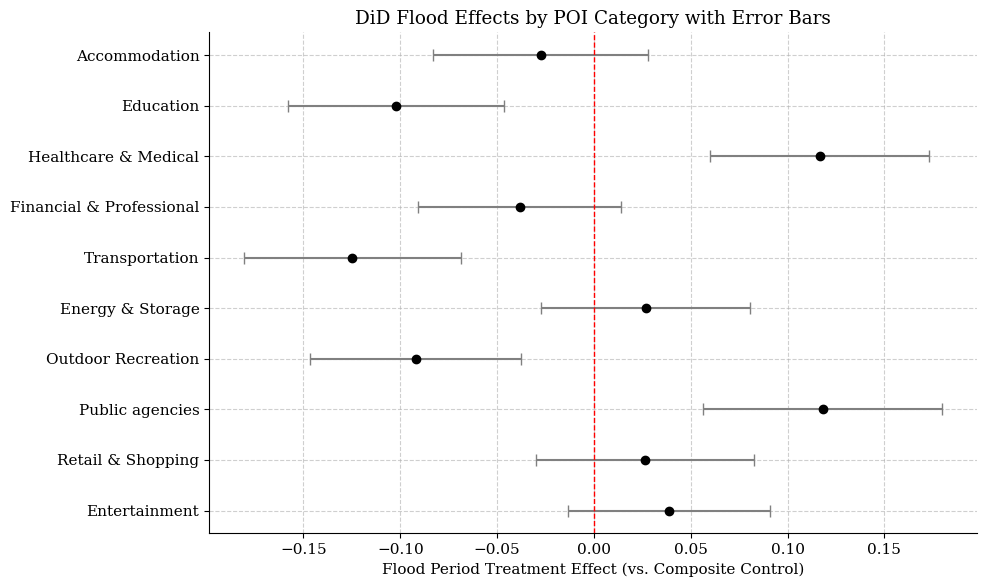

In [26]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import re

# Step 1: Run DiD for each POI type using composite control (Religious + Residential)
poi_types = data_long['type'].unique()
low_impact_controls = ['Religious', 'Residential']
poi_types_treatment = [pt for pt in poi_types if pt not in low_impact_controls]

did_composite_results = {}

for poi_type in poi_types_treatment:
    compare_data = data_long[data_long['type'].isin([poi_type] + low_impact_controls)].copy()
    compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)
    compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
    compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
    compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

    formula = (
        'MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + '
        'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int'
    )

    model = smf.ols(formula=formula, data=compare_data)
    results = model.fit()

    def format_coef_with_se(coef, se, pval):
        stars = ''
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        return f"{coef:.4f}{stars}\n({se:.4f})"

    did_composite_results[poi_type] = {
        'Treatment×PreFlood': format_coef_with_se(
            results.params['POI_PreFlood_Int'], results.bse['POI_PreFlood_Int'], results.pvalues['POI_PreFlood_Int']),
        'Treatment×Flood': format_coef_with_se(
            results.params['POI_Flood_Int'], results.bse['POI_Flood_Int'], results.pvalues['POI_Flood_Int']),
        'Treatment×PostFlood': format_coef_with_se(
            results.params['POI_PostFlood_Int'], results.bse['POI_PostFlood_Int'], results.pvalues['POI_PostFlood_Int']),
        'Observations': int(results.nobs),
        'R-squared': f"{results.rsquared:.3f}"
    }

# Step 2: Convert to DataFrame
table4 = pd.DataFrame(did_composite_results).T
table4.index.name = 'POI Category vs. Composite (Religious + Residential)'

# Step 3: Plot flood effects with error bars
poi_list = []
effects = []
errors = []

for poi, row in table4.iterrows():
    effect_str = row['Treatment×Flood']
    match = re.match(r"([-\d\.]+)\**\n\(([\d\.]+)\)", effect_str)
    if match:
        poi_list.append(poi)
        effects.append(float(match.group(1)))
        errors.append(float(match.group(2)))

# Plot
effects = np.array(effects)
errors = np.array(errors)
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(poi_list))

ax.errorbar(effects, y_pos, xerr=errors, fmt='o', color='black', ecolor='gray', capsize=4)
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(poi_list)
ax.set_xlabel('Flood Period Treatment Effect (vs. Composite Control)')
ax.set_title('DiD Flood Effects by POI Category with Error Bars')
ax.invert_yaxis()
ax.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


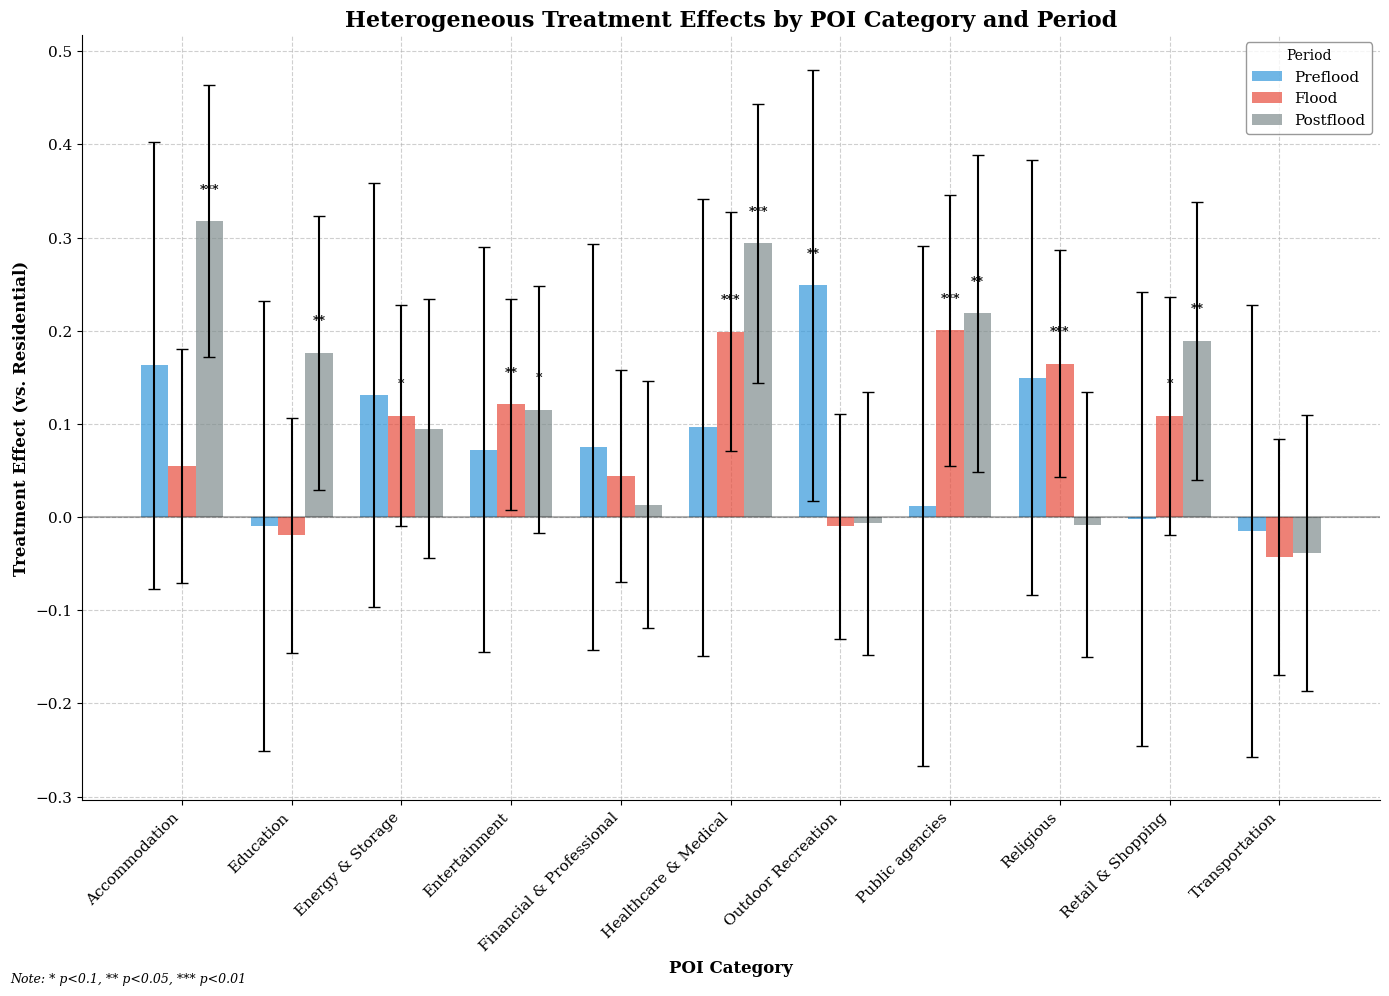

In [11]:
def create_heterogeneous_effects_figure():
    # Extract raw coefficient values and standard errors from the DiD results
    effects_df = pd.DataFrame({
        'POI Type': [],
        'Period': [],
        'Effect': [],
        'SE': [],
        'Lower CI': [],
        'Upper CI': [],
        'p-value': []
    })

    for poi_type in poi_types_treatment:
        # We need to re-run the regression to get the raw values
        compare_data = data_long[data_long['type'].isin([poi_type, 'Residential'])].copy()
        compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)
        compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
        compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
        compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

        formula = ('MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + ' +
                  'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int')

        model = smf.ols(formula=formula, data=compare_data)
        results = model.fit()

        # Add results for each period
        for period, param in [('Preflood', 'POI_PreFlood_Int'),
                             ('Flood', 'POI_Flood_Int'),
                             ('Postflood', 'POI_PostFlood_Int')]:
            effects_df = pd.concat([effects_df, pd.DataFrame({
                'POI Type': [poi_type],
                'Period': [period],
                'Effect': [results.params[param]],
                'SE': [results.bse[param]],
                'Lower CI': [results.params[param] - 1.96 * results.bse[param]],
                'Upper CI': [results.params[param] + 1.96 * results.bse[param]],
                'p-value': [results.pvalues[param]]
            })], ignore_index=True)

    # Create the coefficient plot
    plt.figure(figsize=(14, 10))

    # Define colors for periods
    period_colors = {'Preflood': '#3498db', 'Flood': '#e74c3c', 'Postflood': '#7f8c8d'}

    # Plot each POI type as a group of bars
    unique_pois = sorted(effects_df['POI Type'].unique())
    x_pos = np.arange(len(unique_pois))
    width = 0.25  # Width of bars

    # Plot bars for each period
    for i, period in enumerate(['Preflood', 'Flood', 'Postflood']):
        period_data = effects_df[effects_df['Period'] == period]
        period_data = period_data.sort_values('POI Type', key=lambda x: pd.Categorical(x, categories=unique_pois))

        plt.bar(x_pos + (i-1)*width, period_data['Effect'], width,
                label=period, color=period_colors[period], alpha=0.7)

        # Add error bars
        plt.errorbar(x_pos + (i-1)*width, period_data['Effect'],
                    yerr=1.96 * period_data['SE'], fmt='none', ecolor='black', capsize=4)

        # Add significance stars
        for j, row in period_data.iterrows():
            stars = ''
            if row['p-value'] < 0.01:
                stars = '***'
            elif row['p-value'] < 0.05:
                stars = '**'
            elif row['p-value'] < 0.1:
                stars = '*'

            if stars:
                y_pos = row['Effect'] + (0.03 if row['Effect'] >= 0 else -0.08)
                plt.text(x_pos[unique_pois.index(row['POI Type'])] + (i-1)*width,
                         y_pos, stars, ha='center', fontsize=9, fontweight='bold')

    # Add zero line
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Label the axes
    plt.xlabel('POI Category', fontweight='bold', fontsize=12)
    plt.ylabel('Treatment Effect (vs. Residential)', fontweight='bold', fontsize=12)
    plt.title('Heterogeneous Treatment Effects by POI Category and Period',
              fontsize=16, fontweight='bold')

    # Add x-tick labels
    plt.xticks(x_pos, unique_pois, rotation=45, ha='right')

    # Add legend
    plt.legend(title='Period', title_fontsize=10, frameon=True, framealpha=0.8, edgecolor='grey')

    # Add note about significance levels
    plt.figtext(0.01, 0.01, "Note: * p<0.1, ** p<0.05, *** p<0.01", ha="left", fontsize=9, style='italic')

    plt.tight_layout()
    plt.savefig('figure3_heterogeneous_effects.pdf')

    return plt.gcf()

# Create Figure 3
fig3 = create_heterogeneous_effects_figure()
plt.show()

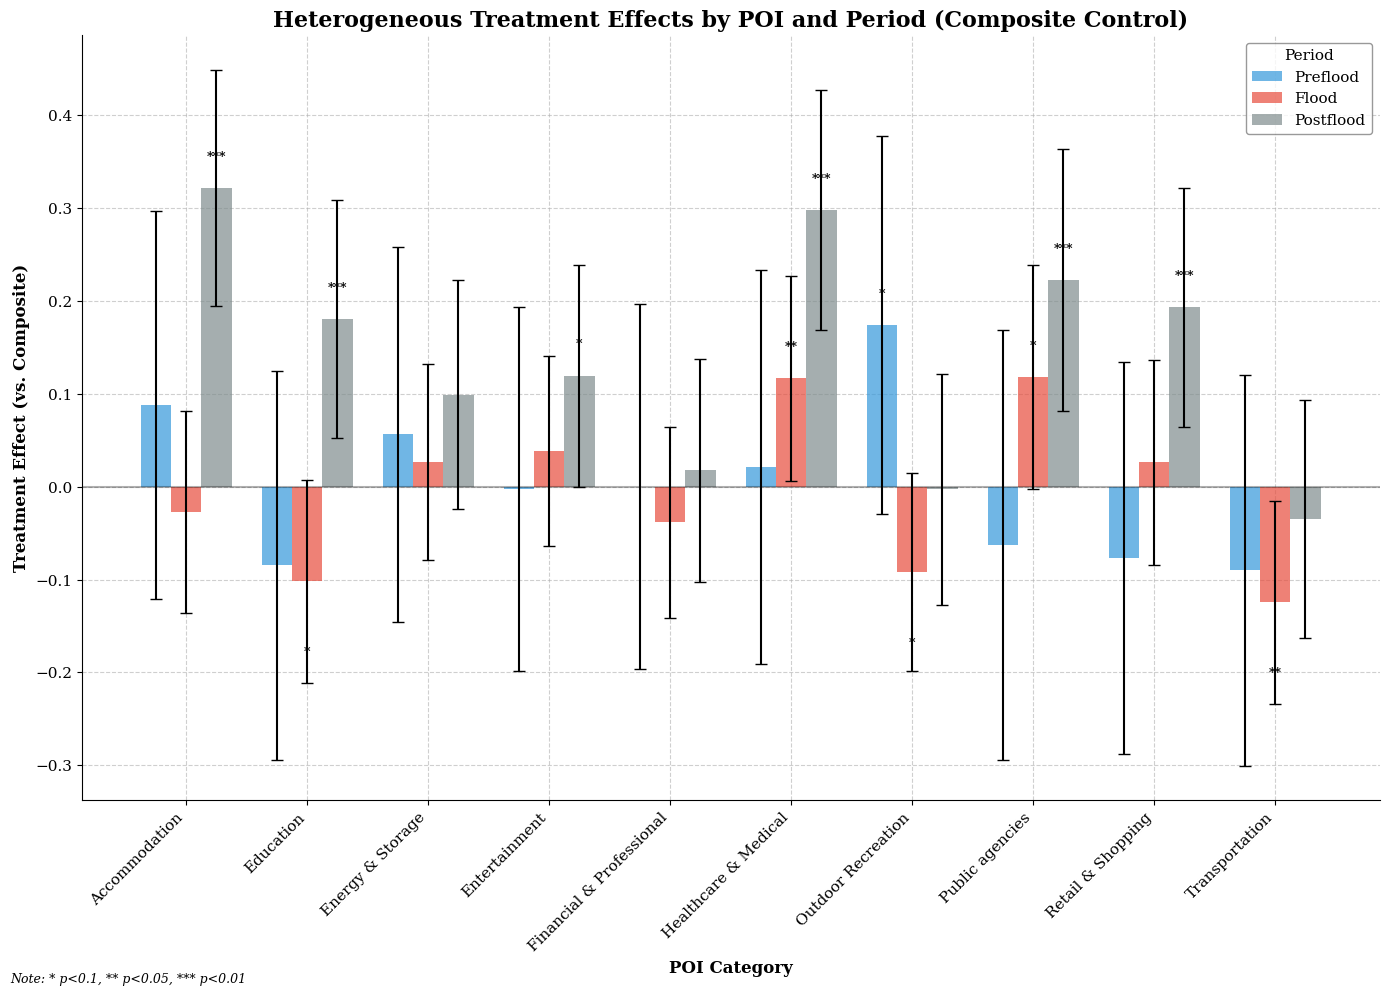

In [31]:
def create_heterogeneous_effects_figure_composite():
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Prepare DataFrame for storing results
    effects_df = pd.DataFrame(columns=[
        'POI Type', 'Period', 'Effect', 'SE', 'Lower CI', 'Upper CI', 'p-value'
    ])

    low_impact_controls = ['Religious', 'Residential']
    poi_types_treatment = [pt for pt in poi_types if pt not in low_impact_controls]

    for poi_type in poi_types_treatment:
        compare_data = data_long[data_long['type'].isin([poi_type] + low_impact_controls)].copy()
        compare_data['POI_Treatment'] = (compare_data['type'] == poi_type).astype(int)
        compare_data['POI_PreFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PreFlood']
        compare_data['POI_Flood_Int'] = compare_data['POI_Treatment'] * compare_data['Flood']
        compare_data['POI_PostFlood_Int'] = compare_data['POI_Treatment'] * compare_data['PostFlood']

        formula = (
            'MinMax_Mobility ~ POI_Treatment + PreFlood + Flood + PostFlood + '
            'POI_PreFlood_Int + POI_Flood_Int + POI_PostFlood_Int'
        )
        model = smf.ols(formula=formula, data=compare_data)
        results = model.fit()

        for period, param in [('Preflood', 'POI_PreFlood_Int'),
                              ('Flood', 'POI_Flood_Int'),
                              ('Postflood', 'POI_PostFlood_Int')]:
            effects_df = pd.concat([effects_df, pd.DataFrame({
                'POI Type': [poi_type],
                'Period': [period],
                'Effect': [results.params[param]],
                'SE': [results.bse[param]],
                'Lower CI': [results.params[param] - 1.96 * results.bse[param]],
                'Upper CI': [results.params[param] + 1.96 * results.bse[param]],
                'p-value': [results.pvalues[param]]
            })], ignore_index=True)

    # === Plot ===
    plt.figure(figsize=(14, 10))
    period_colors = {'Preflood': '#3498db', 'Flood': '#e74c3c', 'Postflood': '#7f8c8d'}
    unique_pois = sorted(effects_df['POI Type'].unique())
    x_pos = np.arange(len(unique_pois))
    width = 0.25

    for i, period in enumerate(['Preflood', 'Flood', 'Postflood']):
        period_data = effects_df[effects_df['Period'] == period]
        period_data = period_data.sort_values('POI Type', key=lambda x: pd.Categorical(x, categories=unique_pois))
        plt.bar(x_pos + (i - 1) * width, period_data['Effect'], width,
                label=period, color=period_colors[period], alpha=0.7)

        plt.errorbar(x_pos + (i - 1) * width, period_data['Effect'],
                     yerr=1.96 * period_data['SE'], fmt='none',
                     ecolor='black', capsize=4)

        for j, row in period_data.iterrows():
            stars = ''
            if row['p-value'] < 0.01:
                stars = '***'
            elif row['p-value'] < 0.05:
                stars = '**'
            elif row['p-value'] < 0.1:
                stars = '*'
            if stars:
                y_pos = row['Effect'] + (0.03 if row['Effect'] >= 0 else -0.08)
                plt.text(x_pos[unique_pois.index(row['POI Type'])] + (i - 1) * width,
                         y_pos, stars, ha='center', fontsize=9, fontweight='bold')

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('POI Category', fontweight='bold', fontsize=12)
    plt.ylabel('Treatment Effect (vs. Composite)', fontweight='bold', fontsize=12)
    plt.title('Heterogeneous Treatment Effects by POI and Period (Composite Control)', fontsize=16, fontweight='bold')
    plt.xticks(x_pos, unique_pois, rotation=45, ha='right')
    plt.legend(title='Period', frameon=True, framealpha=0.8, edgecolor='grey')
    plt.figtext(0.01, 0.01, "Note: * p<0.1, ** p<0.05, *** p<0.01", ha='left', fontsize=9, style='italic')
    plt.tight_layout()
    plt.savefig('figure3_heterogeneous_effects_composite.pdf')
    return plt.gcf()

# Create the plot using composite control
fig3_composite = create_heterogeneous_effects_figure_composite()
plt.show()


In [12]:
# Add formal parallel trends test
print("\nFormal Parallel Trends Test:")
print("-" * 80)

# Create pre-flood trend interaction
data_long['Day'] = data_long['Date'].dt.day
pre_flood_data = data_long[data_long['Period'] == 'benchmark'].copy()
pre_flood_data['Treatment_Day'] = pre_flood_data['Treatment'] * pre_flood_data['Day']

# Run the test
parallel_model = smf.ols('MinMax_Mobility ~ Treatment + Day + Treatment_Day', data=pre_flood_data)
parallel_results = parallel_model.fit(cov_type='cluster', cov_kwds={'groups': pre_flood_data['type']})

print(f"Treatment×Day Coefficient: {parallel_results.params['Treatment_Day']:.4f}")
print(f"p-value: {parallel_results.pvalues['Treatment_Day']:.4f}")
if parallel_results.pvalues['Treatment_Day'] > 0.05:
    print("Conclusion: Cannot reject the parallel trends assumption (p > 0.05)")
else:
    print("Conclusion: Parallel trends assumption may be violated (p < 0.05)")

# Display additional methodological notes
print("\nMethodological Notes:")
print("-" * 80)
print("1. Control Group: Residential was selected as the control group based on minimal")
print("   disruption during flood periods (stability metric: 0.010684).")
print("2. Normalization: Min-Max scaling was applied to each POI category to enable")
print("   direct comparison across different types of locations.")
print("3. Statistical Inference: Standard errors were clustered at the POI type level")
print("   to account for within-group correlation.")
print("4. Period Definitions:")
print("   - Benchmark: June 1-11, 2020")
print("   - Pre-Flood: June 12-16, 2020")
print("   - Flood: June 17-July 8, 2020")
print("   - Post-Flood: July 9-23, 2020")
print("5. Robustness: Event study analysis confirms the DiD findings using an alternative")
print("   day-by-day estimation approach with bootstrapped confidence intervals.")


Formal Parallel Trends Test:
--------------------------------------------------------------------------------
Treatment×Day Coefficient: 0.0093
p-value: 0.0089
Conclusion: Parallel trends assumption may be violated (p < 0.05)

Methodological Notes:
--------------------------------------------------------------------------------
1. Control Group: Residential was selected as the control group based on minimal
   disruption during flood periods (stability metric: 0.010684).
2. Normalization: Min-Max scaling was applied to each POI category to enable
   direct comparison across different types of locations.
3. Statistical Inference: Standard errors were clustered at the POI type level
   to account for within-group correlation.
4. Period Definitions:
   - Benchmark: June 1-11, 2020
   - Pre-Flood: June 12-16, 2020
   - Flood: June 17-July 8, 2020
   - Post-Flood: July 9-23, 2020
5. Robustness: Event study analysis confirms the DiD findings using an alternative
   day-by-day estimation app